Importing Libraries

In [66]:

import numpy as np
import pandas as pd
import seaborn as sns
from prometheus_client import Summary
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Importing the dataset

In [67]:
df=pd.read_excel("C:/Users/PAVILION/PycharmProjects/PythonProject4/concrete data.xlsx")

### Exploratory Data Analysis

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1133 non-null   float64
 1   Blast-furnace Slag  1133 non-null   float64
 2   Fly Ash             1133 non-null   float64
 3   Water               1133 non-null   float64
 4   Super-plasticizer   1133 non-null   float64
 5   Coarse Aggregate    1133 non-null   float64
 6   Fine Aggregate      1133 non-null   float64
 7   Age of testing      1133 non-null   int64  
 8   final               1133 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 79.8 KB


In [69]:
df.head()
df.dtypes


Cement                float64
Blast-furnace Slag    float64
Fly Ash               float64
Water                 float64
Super-plasticizer     float64
Coarse Aggregate      float64
Fine Aggregate        float64
Age of testing          int64
final                 float64
dtype: object

NUMERICAL VARIABLE ANALYSIS:
1. Analaysis of the relationship using pairwise scatter plots for different parameters:

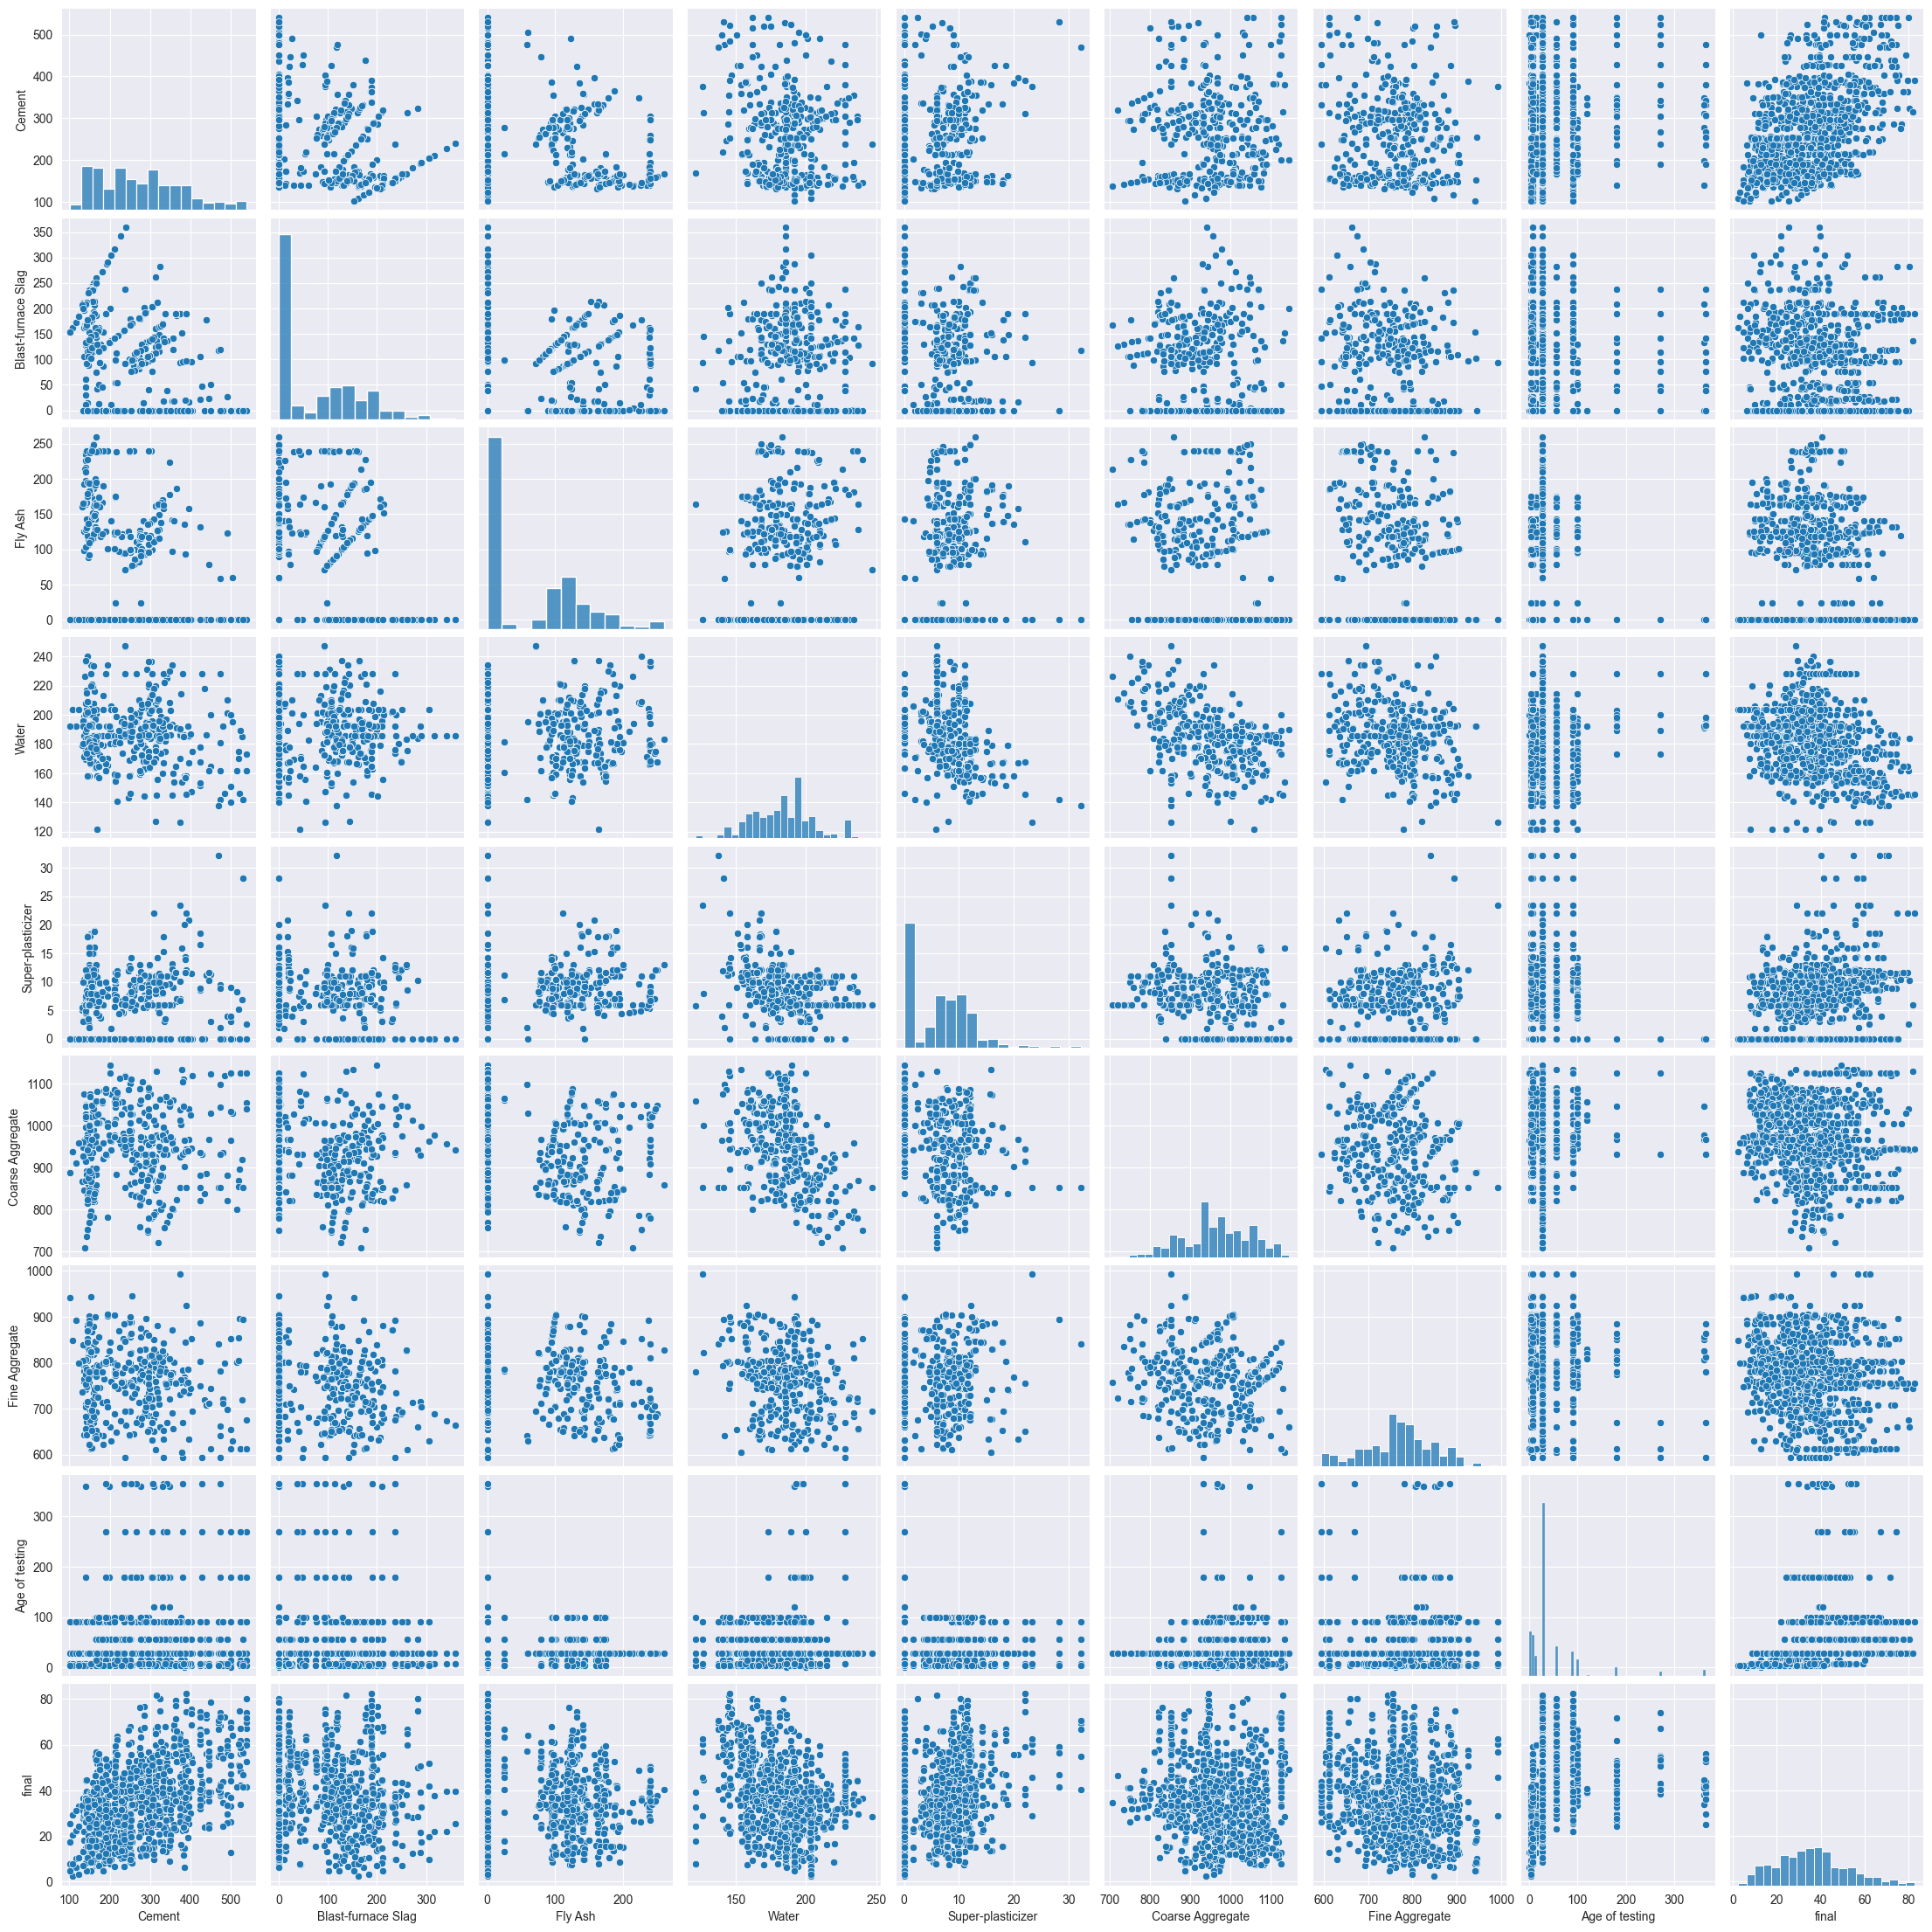

In [70]:
sns.pairplot(df)

From initial inspection, it appear that the parameters dont have avery strong relationship with each other. We further calculate the VIF for each parameter to determine the feasibility of a Multiple linear regression model:


In [71]:
data=df.drop("final",axis=1)
columns=data.columns
# data.head()


In [72]:
vif = pd.DataFrame()
vif["feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif)

              feature        VIF
0              Cement  14.455934
1  Blast-furnace Slag   3.162687
2             Fly Ash   4.058628
3               Water  72.167208
4   Super-plasticizer   5.169142
5    Coarse Aggregate  73.225174
6      Fine Aggregate  72.519225
7      Age of testing   1.692276


The VIF is observed to be high for several features.

In [73]:
scaler = StandardScaler()

# Fit on training data
scaler.fit(data)

# Transform both train and test data
data = scaler.transform(data)
data=pd.DataFrame(data,columns=columns)



In [74]:
vif = pd.DataFrame()
vif["feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif)

              feature       VIF
0              Cement  7.156083
1  Blast-furnace Slag  6.966356
2             Fly Ash  6.587575
3               Water  6.721945
4   Super-plasticizer  2.652804
5    Coarse Aggregate  5.929215
6      Fine Aggregate  6.802994
7      Age of testing  1.108556


After scaling, the VIF has been reduced.Now we use this dataset for our subsequent models

In [75]:
X_sm = sm.add_constant(data)
model = sm.OLS(df["final"], X_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     222.6
Date:                Fri, 26 Dec 2025   Prob (F-statistic):          1.34e-225
Time:                        12:54:39   Log-Likelihood:                -4217.8
No. Observations:                1133   AIC:                             8454.
Df Residuals:                    1124   BIC:                             8499.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.8380      0

Since the VIF hints at possible multicollinearity , we employ principal component analysis to transform the features and remove multicollinearity.

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(data)
pca.n_components_




np.int64(6)

In [77]:
import pandas as pd

loading_matrix = pd.DataFrame(
    pca.components_,
    columns=data.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)


The relative weightage of each of the original features to the principal components can be observed from the table below:

In [78]:
abs(loading_matrix)


,Cement,Blast-furnace Slag,Fly Ash,Water,Super-plasticizer,Coarse Aggregate,Fine Aggregate,Age of testing
PC1,0.112956,0.165573,0.369939,0.537617,0.522098,0.047268,0.399333,0.315678
PC2,0.483651,0.558536,0.263314,0.278413,0.139683,0.502815,0.125774,0.138265
PC3,0.581724,0.311606,0.471175,0.144260,0.344898,0.449391,0.027197,0.005955
PC4,0.244401,0.521222,0.403847,0.328694,0.101333,0.499765,0.022301,0.370045
PC5,0.267580,0.045106,0.339268,0.093048,0.300066,0.235101,0.802234,0.117107
PC6,0.209937,0.239933,0.013883,0.278353,0.262355,0.159595,0.002112,0.852279


In [79]:
x_train,x_test,y_train,y_test=train_test_split(data,df['final'],test_size=0.2,random_state=42)
# x_train.shape
# data.shape

### 1.LINEAR REGRESSION MODEL

In [80]:
from sklearn.model_selection import train_test_split

x_pca_train,x_pca_test,y_pca_train,y_pca_test=train_test_split(x_pca,df['final'],test_size=0.2,random_state=42)

In [81]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x_pca_train,y_pca_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [82]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error,r2_score
y_pca_pred=regressor.predict(x_pca_test)
print(f" The  RMSE is:{root_mean_squared_error(y_pca_test, y_pca_pred)}"
      f" The  MAE is:{mean_absolute_error(y_pca_test,y_pca_pred)}"
      f" The  R2 is:{r2_score(y_pca_test,y_pca_pred)}")

 The  RMSE is:10.955709695536244 The  MAE is:8.584410295621126 The  R2 is:0.5533377979123728


In [83]:
perf=[]
perf.append({
    "Model": "Linear Regression (PCA)",
    "R2": r2_score(y_pca_test,y_pca_pred)
})

### 2.DECISION TREE BASED REGRESSION MODEL

In [84]:
from sklearn.tree import DecisionTreeRegressor
regressor=DecisionTreeRegressor(max_depth=5)
regressor.fit(x_train,y_train)
y_pred_tree=regressor.predict(x_test)
print(f" The  RMSE is:{root_mean_squared_error(y_test,y_pred_tree)}"
      f" The  MAE is:{mean_absolute_error(y_test,y_pred_tree)}"
      f" The  R2 is:{r2_score(y_test,y_pred_tree)}")

 The  RMSE is:8.619729125689693 The  MAE is:6.6022444003223475 The  R2 is:0.7235061932699379


In [85]:
perf.append({
    "Model": "Desc.Tree",
    "R2": r2_score(y_test,y_pred_tree)
})

The structure of the decision tree is as follows:

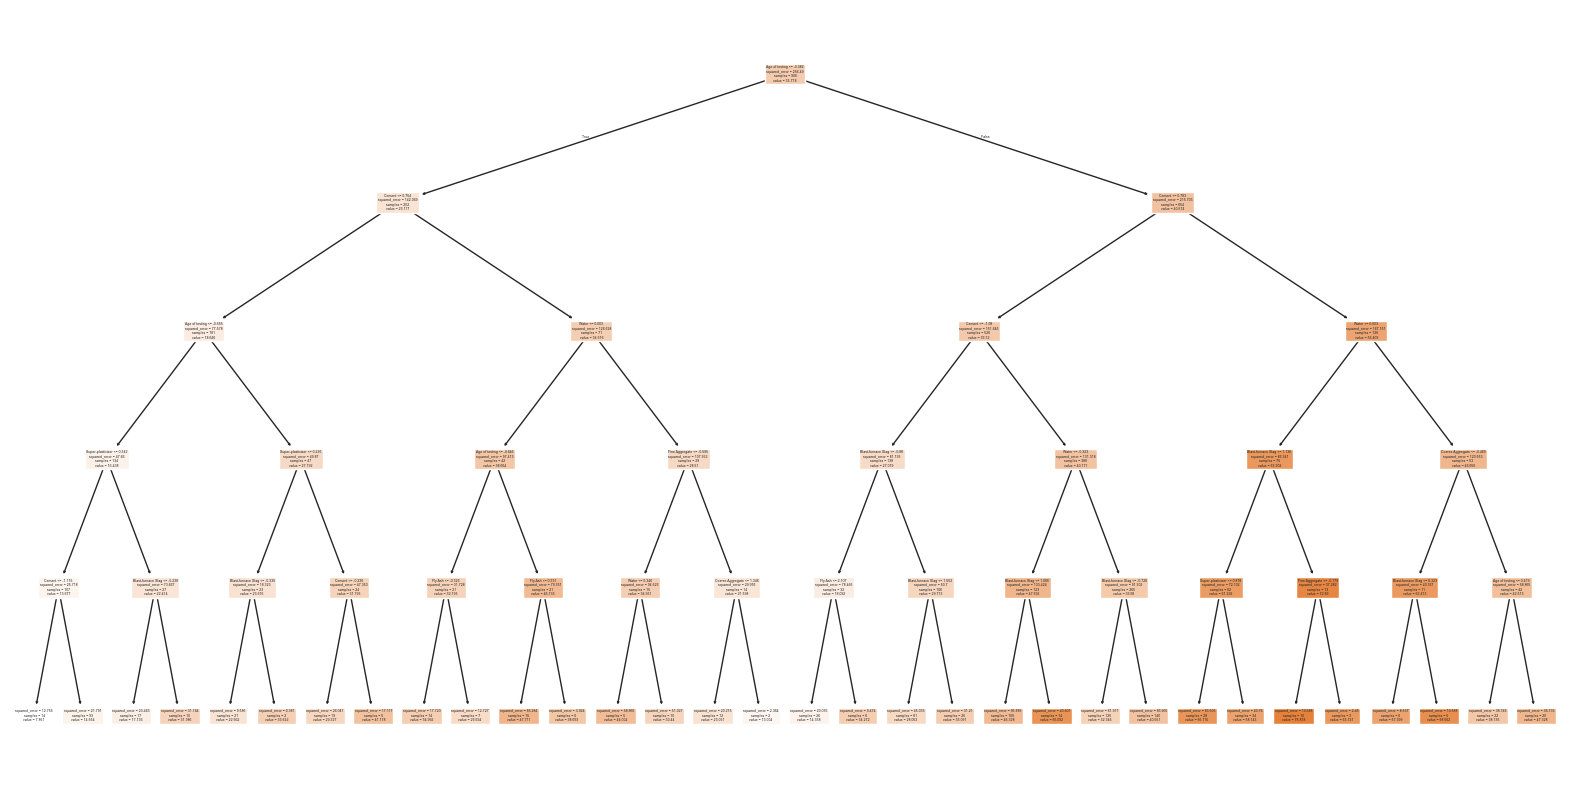

In [86]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(
    regressor,
    feature_names=x_train.columns,
    class_names=True,
    filled=True
)
plt.show()


As decision trees are high variance models, we further use cross validation to understand how the model performs on multiple splits of data.

In [87]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

results = cross_validate(
    model,
    data,
    df['final'],
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring:
    print(metric, results[f'test_{metric}'].mean())


rmse -8.36592975406631
mae -6.339728432423782
r2 0.7279287304576746


### RANDOM FOREST

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,GridSearchCV

rf=RandomForestRegressor(n_jobs=-1,random_state=42)

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='rmse',     # metric used to select best model
    n_jobs=-1,
    verbose=2
)

grid.fit(data, df['final'])



Fitting 5 folds for each of 108 candidates, totalling 540 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'mae': 'neg_mean_absolute_error', 'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'rmse'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"ver

In [89]:
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

results = grid.cv_results_

mean_rmse = -results['mean_test_rmse'][grid.best_index_]
mean_mae  = -results['mean_test_mae'][grid.best_index_]
mean_r2   =  results['mean_test_r2'][grid.best_index_]

print("RMSE:", mean_rmse)
print("MAE :", mean_mae)
print("R2  :", mean_r2)


Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 4.93865674148956
RMSE: 4.93865674148956
MAE : 3.5193968208317856
R2  : 0.9048888917980851


In [90]:
perf.append({
    "Model": "R.Forest",
    "R2": mean_r2
})

### XGBOOST

In [91]:
from xgboost import XGBRegressor
xr=XGBRegressor()
xr.fit(data, df['final'])
y_pred_xgb=xr.predict(x_test)


In [92]:
print(f" The  RMSE is:{root_mean_squared_error(y_test,y_pred_xgb)}"
      f" The  MAE is:{mean_absolute_error(y_test,y_pred_xgb)}"
      f" The  R2 is:{r2_score(y_test,y_pred_xgb)}")

 The  RMSE is:0.9477431289361309 The  MAE is:0.5335276606754241 The  R2 is:0.9966574380881297


In [93]:
from sklearn.model_selection import KFold,GridSearchCV

xr=XGBRegressor(n_jobs=-1,random_state=42)


cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

grid = GridSearchCV(
    estimator=xr,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='rmse',     # metric used to select best model
    n_jobs=-1,
    verbose=2
)

grid.fit(data, df['final'])


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\PAVILION\PycharmProjects\PythonProject4\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:56:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'mae': 'neg_mean_absolute_error', 'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'rmse'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"v

In [94]:
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

results = grid.cv_results_

mean_rmse = -results['mean_test_rmse'][grid.best_index_]
mean_mae  = -results['mean_test_mae'][grid.best_index_]
mean_r2_xgb  =  results['mean_test_r2'][grid.best_index_]

print("RMSE:", mean_rmse)
print("MAE :", mean_mae)
print("R2 :", mean_r2_xgb)

Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 4.360015217616508
RMSE: 4.360015217616508
MAE : 2.907619040192859
R2 : 0.9261454619467708


In [95]:
perf.append({
    "Model": "XGB",
    "R2":mean_r2_xgb
})

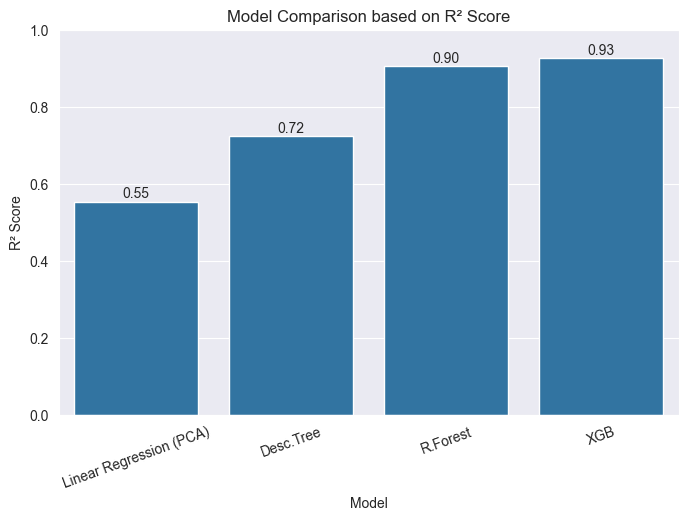

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert list to DataFrame
prf_df = pd.DataFrame(perf)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=prf_df,
    x="Model",
    y="R2"
)

plt.title("Model Comparison based on R² Score")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.xticks(rotation=20)


for index, row in prf_df.iterrows():
    plt.text(index, row["R2"] + 0.01, f"{row['R2']:.2f}", ha="center")

plt.show()


### Summary
Tree-based ensemble models significantly outperform linear baselines, with XGBoost achieving the highest R² score (~0.93), followed closely by Random Forest (~0.90).This highlights the effectiveness of ensemble methods in capturing complex nonlinear relationships in the data.